# Introduction

For my final project I will classify hate speech from tweets using the famous tweet sentiment analysis.

I hypothesize that a network-based machine learning algorithm will best determine hate speech.

I will clean the data so that classic classification models can be used. Then, I will determine the “best” algorithm based on the F1 score and the accuracy of the results. I will compare different vectorization methods like Tf-idf and bag of words. Then I will compare different vectorizers with a neural network, logistics regression, support vector machine and random forest algorithm.

In [50]:
import re    # for regular expressions
import numpy as np
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neural_network import MLPClassifier



# Data Wrangling

## Load Dataset


The datasets are loaded below as separate testing and training datasets.

In [43]:
train  = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Train

The training data contains 31962 total tweets.

In [3]:
train.shape

(31962, 3)

In [4]:
train.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


The training dataset shows there are tokens and other string/characters in the tweets that would need to be cleaned from the dataset.

The training set shows labels '1' denotes which tweet is labeled as hate speech and label '0' denotes which tweet is labeled as not hate speech.

#### Not Hate Speech

In [5]:
train[train['label'] == 0].head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


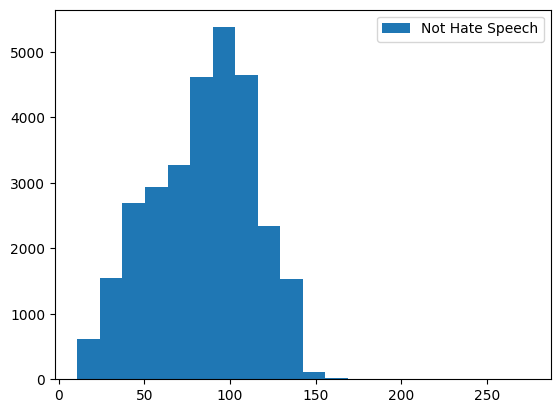

In [6]:
#plot the dataset hate speech and not lenght
train_plot = train[train['label'] == 0]['tweet'].str.len()
plt.hist(train_plot, bins=20, label="Not Hate Speech")
plt.legend()
plt.show()

The above historgram shows the length of the tweets in the not hate speech dataset. The longest tweet is about 150 characters long. Most tweets (about 5000 in this dataset) are 100 characters long. The original limit of tweets is 140 characters long.

#### Hate Speech

In [7]:
train[train['label'] == 1].head(10)

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


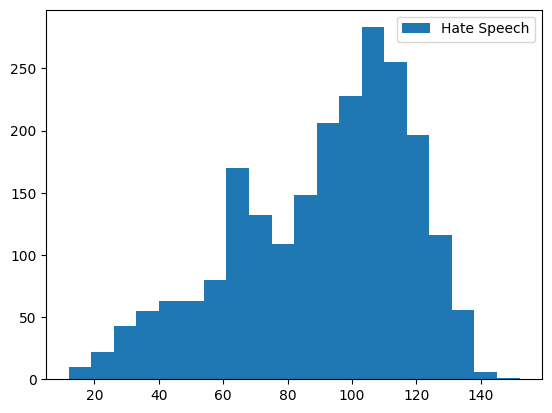

In [8]:
train_plot = train[train['label'] == 1]['tweet'].str.len()
plt.hist(train_plot, bins=20, label="Hate Speech")
plt.legend()
plt.show()

Hate speech tweet character lengths are skewed more to the right. They are also more tweets that are shorter in length (around the 20 character length).

#### Hate Speech vs Not Hate Speech

The number of not hate speech labeled tweets in the training dataset is 29720. The number of hate speech are 2242.

In [9]:
train["label"].value_counts()


label
0    29720
1     2242
Name: count, dtype: int64

#### Distribution of Tweets in Testing Data and Training Data

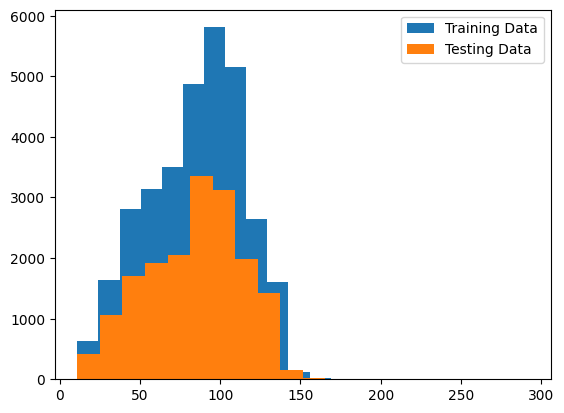

In [10]:
#plot the dataset hate speech and not lenght
train_plot = train['tweet'].str.len()
test_plot = test['tweet'].str.len()
plt.hist(train_plot, bins=20, label="Training Data")
plt.hist(test_plot, bins=20, label="Testing Data")
plt.legend()
plt.show()

The length of the tweets in both the training and the test have a similar distribution. The training data contains more tweets than the testing data.

### Clean the data

In order to apply any machine learning algorithms to the dataset, I need to remove the different tokens like @ and other non alpha numeric symbols. The exception I will be keeping is the #. # followed directly by a word, phrase and a name is a hashtag. Hashtags can also be helpful in classifying hateful tweets from non hateful speech. The tweet cleaner function removes any pattern that is specified in the parameters.

In [11]:
def tweet_cleaner(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

In [12]:
train.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


Below I cleaned the data of all "@" and any other non alphanumerical characters.

In [13]:
## clean the training data
## get rid of @
train['clean_tweet'] = np.vectorize(tweet_cleaner)(train['tweet'], "@[\w]*")
train.head(10)


,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


In [14]:
#keep all alphanumerical words and hashtags
train['clean_tweet'] = train['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
train.head(10)

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


In [15]:
train['clean_tweet'] = train['clean_tweet'].apply(lambda x: ' '.join([t for t in x.split() if len(t)>3]))
train.head(10)

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit can't cause they don't off...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time urð±!!! ððð...
4,5,0,factsguide: society now #motivation,factsguide: society #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fare talking before they leave. cha...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0,the next school year is the year for exams.ð...,next school year year exams.ð¯ can't think a...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,won!!! love land!!! #allin #cavs #champions #c...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here it's #gr8


Tokenize the Text before we normalize.
When we want to apply tokenization in text data like tweets, the tokenizers mentioned above can’t produce practical tokens. Through this issue, NLTK has a rule based tokenizer special for tweets. We can split emojis into different words if we need them for tasks like sentiment analysis.

In [18]:
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [19]:
from nltk.tokenize import TweetTokenizer
nltk.download('punkt')
tt = TweetTokenizer()
tokenized_tweet = train['clean_tweet'].apply(tt.tokenize) # tokenizing
stop_words = set(stopwords.words("english"))
tokenized_tweet = tokenized_tweet.apply(lambda x: [word for word in x if word not in stop_words])
tokenized_tweet.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    [father, dysfunctional, selfish, drags, kids, ...
1    [thanks, #lyft, credit, can't, cause, offer, w...
2                                    [bihday, majesty]
3    [#model, love, take, time, urð, , , ±, !, !,...
4                [factsguide, :, society, #motivation]
Name: clean_tweet, dtype: object

### Normalize the text

In order to decrease the randomness of the text, I normalized the data ustilizing the function `PorterStemmer`.

In [20]:
from nltk.stem.porter import *
stemmer = PorterStemmer()
# stemming
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [21]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
train['clean_tweet'] = tokenized_tweet

### Word Frequency

By using a word cloud I am able to visualize the words in the cleaned tweet dataset. The most common words are words are larger than others. According tot the graphic words like "thank", "today" and "love" are most frequent.

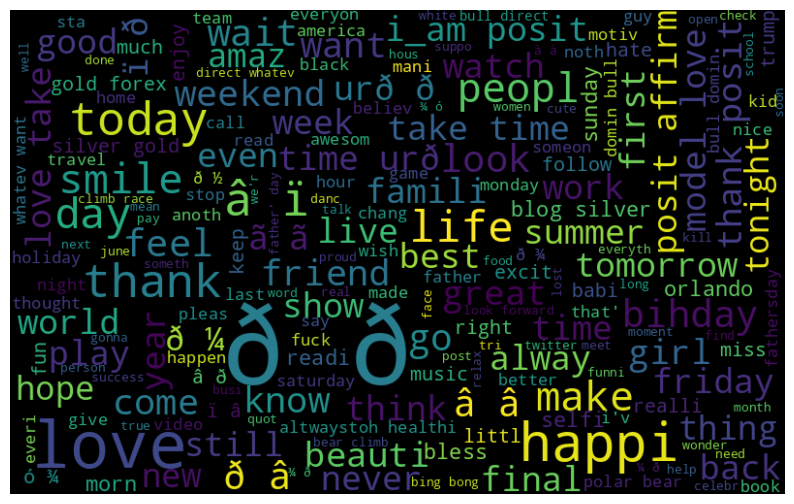

In [22]:
## word cloud for most used words
## bar chart

from wordcloud import WordCloud

all_words = ' '.join([text for text in train['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()


In the non hate speech section of the training dataset. The most common words are "thank", "today" and "love".

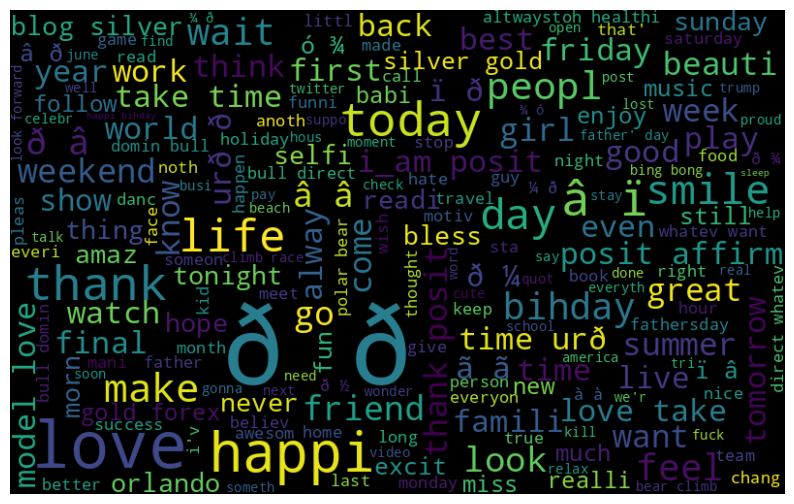

In [23]:
words =' '.join([text for text in train['clean_tweet'][train['label'] == 0]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In the hate speech section of the training dataset. The most common words are "hate", "trump" and "obama".

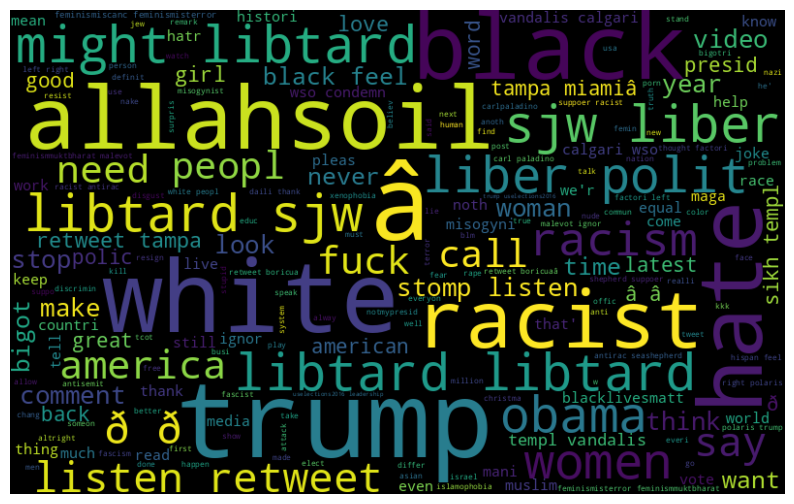

In [24]:
words =' '.join([text for text in train['clean_tweet'][train['label'] == 1]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Model Creation



## Vectorizers
 Now that the dataset is clean, I will use two different vectorizers on the different machine learning algorithms to determine the best models.

### Tfdif Vectorizer

In [25]:
vectorizer = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            )
X = vectorizer.fit_transform(train["clean_tweet"])

X_train, X_test, y_train, y_test = train_test_split(X, train["label"], test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


#### Random Forest

Random Forest is a machine learning algorithm combining multiple decision trees' output to reach a single result. Random forest algorithms have three main hyperparameters, which must be set before training. These include node size, the number of trees, and the number of features sampled. Random Forest has a reduced risk of overfitting compared to decision trees. Since there are a robust number of decisions in a random forest, the classifier won't overfit the model since the averaging of uncorrelated trees lowers the overall variance and prediction error. It also performs well for estimating missing values and maintaining accuracy when a portion of the data is missing. Finally, it can evaluate variable importance, or contribution, to the model.

In [26]:
rf_classifier = RandomForestClassifier(n_estimators=400, random_state=11)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9607383075238543
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5937
           1       0.86      0.54      0.66       456

    accuracy                           0.96      6393
   macro avg       0.91      0.76      0.82      6393
weighted avg       0.96      0.96      0.96      6393



The Random Forest Model was able to achieve a 96% accuracy and f1 score for label `0` 98% and for label `1` 66%.

#### SVM

A support vector machine (SVM) is a machine learning algorithm that solves complex classification, regression, and outlier detection problems. It utilizes optimal data transformations to determine the boundaries between data points based on predefined classes, labels, or outputs.

The accuracy for the SVM is slightly lower than the Random Forest Classifier.

In [27]:
svm_classifier = svm.SVC(kernel='linear', C=1, probability=True)
svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9608947286094166
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5937
           1       0.90      0.51      0.65       456

    accuracy                           0.96      6393
   macro avg       0.93      0.75      0.82      6393
weighted avg       0.96      0.96      0.96      6393



The Support Vector macine was able to achieve a 96% accuracy and f1 score for label `0` 98% and for label `1` 65%. This is similar and comparable to the Random Forest Model.  

#### Multinomial Naive Bayes

Classifier based on the Bayes theorem. The model assumes feature independence, which means that the presence of one feature does not affect the presence of another (which may not be true in practice).

Multinomial Naive Bayes is a probabilistic classifier to calculate the probability distribution of text data.

In [28]:
mnb_classifier = MultinomialNB()
mnb_classifier.fit(X_train, y_train)

y_pred = mnb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9449397778820585
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.86      0.27      0.41       456

    accuracy                           0.94      6393
   macro avg       0.90      0.63      0.69      6393
weighted avg       0.94      0.94      0.93      6393



The Support Vector macine was able to achieve a 94% accuracy and f1 score for label `0` 97% and for label `1` 41%. This is the worst performing model so far.

#### Logistic regresion

Logistic regression is a classic binary classifier. Using the logistic regression obtains a 95% accuracy in predicting tweets as hate speech or not.

In [29]:
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)

y_pred = lr_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9488503050211169
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      5937
           1       0.92      0.31      0.46       456

    accuracy                           0.95      6393
   macro avg       0.93      0.65      0.72      6393
weighted avg       0.95      0.95      0.94      6393



The Logistic Regression macine was able to achieve a 94% accuracy and f1 score for label `0` 97% and for label `1` 46%. This is similar and comparable to the Random Forest Model.  This performance is comparable to the Multinomial Naive Bayes Model.

#### MLP Classifier

MLP Classifier is a method that belongs to the artifical neural network family. It is a flexible classification model that can hadle variety of classification problems.

In [51]:
mlp_classifier = MLPClassifier()
mlp_classifier.fit(X_train, y_train)

y_pred = mlp_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

Accuracy: 0.9562020960425466
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5937
           1       0.70      0.68      0.69       456

    accuracy                           0.96      6393
   macro avg       0.84      0.83      0.83      6393
weighted avg       0.96      0.96      0.96      6393



The MLP Classifier performed the best out of all of the models. The F1-Score shows a 98% for label `0` and 69% for label `1`. While the accuracy is slightly lower than the random forest, the f1-score shows the trade off in predictions.

### Bag of Words

Using the Bag of Words or otherwise known as the CountVectorizer and the different models caused my machine to crash after using all the available RAM.

The test dataset also needs to be cleaned before I can apply the model to it.

In [44]:
test["clean_tweet"]= np.vectorize(tweet_cleaner)(test['tweet'], "@[\w]*")

In [45]:
#keep all alphanumerical words and hashtags
test['clean_tweet'] = test['clean_tweet'].str.replace("[^a-zA-Z#]", " ")
test.head(10)

,id,tweet,clean_tweet
0,31963,#studiolife #aislife #requires #passion #dedic...,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...,#white #supremacists want everyone to see th...
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew...","3rd #bihday to my amazing, hilarious #nephew..."
5,31968,choose to be :) #momtips,choose to be :) #momtips
6,31969,something inside me dies ð¦ð¿â¨ eyes nes...,something inside me dies ð¦ð¿â¨ eyes nes...
7,31970,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...,#finished#tattoo#inked#ink#loveitâ¤ï¸ #â¤ï¸...
8,31971,@user @user @user i will never understand why...,i will never understand why my dad left me...
9,31972,#delicious #food #lovelife #capetown mannaep...,#delicious #food #lovelife #capetown mannaep...


# Prediction

In [52]:
test_vec = vectorizer.transform(test['tweet'])
test_pred = mlp_classifier.predict(test_vec)


In [53]:
test["label"] =test_pred

In [54]:
test

,id,tweet,clean_tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,#white #supremacists want everyone to see th...,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...","3rd #bihday to my amazing, hilarious #nephew...",0
...,...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,thought factory: left-right polarisation! #tru...,1
17193,49156,feeling like a mermaid ð #hairflip #neverre...,feeling like a mermaid ð #hairflip #neverre...,0
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,#hillary #campaigned today in #ohio((omg)) &am...,0
17195,49158,"happy, at work conference: right mindset leads...","happy, at work conference: right mindset leads...",0


# Conclusion

In conclusion, there were two high perfroming models; The Random forest and the MLP. Both models were able to achieve a 96% accuracy. Due to computational limitations, I was unable to create and compare with other vectorizers like the Bag of Words.

Utilizing the TweetTokenizer allowed for the model to properly consider the hashtags as words in the model.

In any future iterations I would utilize the Random Forest of MLP classifier. In both cases models the use networks or graphs as their basis performed the most optimally.
